In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); 
using ForwardDiff
using Test
using RobotZoo: PlanarQuadrotor
using RobotDynamics
using LinearAlgebra
using StaticArrays
using SparseArrays
using Plots
using Printf

include("quadratic_cost.jl")
include("quadrotor.jl")

 Activating environment at `~/Classes/OptimalControl/hw3_solutions/Project.toml`


run_tests (generic function with 1 method)

# Question 1: Iterative LQR (50 pts)
In this problem you'll implement iterative LQR (ilQR), the Gauss-Newton approximation of differential dynamic programming (DDP). You'll use it to generate trajectories for a planar quadrotor, including a flip. In the last part of the problem, you'll track the trajectory to make it robust to wind.

## The Model
We'll be using the same planar quadrotor model we saw in class. The dynamics are fairly simple:

$$ 
x = \begin{bmatrix} p_x \\ p_z \\ \theta \\ v_x \\ v_z \\ \omega \end{bmatrix}, \quad
\dot{x} = \begin{bmatrix} v_x \\ v_z \\ \omega \\ 
\frac{1}{m} (u_1 + u_2) \sin{\theta} \\
\frac{1}{m} (u_1 + u_2) \cos{\theta} - g \\
\frac{l}{J} (u_2 - u_1) 
\end{bmatrix}
$$
with the following model parameters:
* $m$: mass (kg)
* $J$: moment of inertia
* $l$: distance between motors

In [2]:
# Problem Setup
model = PlanarQuadrotor()
n,m = size(model)          # state and control dimensions
dt = 0.025                 # time step (sec)
tf = 1.5                   # time horizon (sec)
T = Int(tf/dt) + 1         # number of time steps

# Initial & final condition
x0    = SA_F64[-3, 1, 0, 0, 0, 0]                    # initial state
xgoal = SA_F64[+3, 1, 0, 0, 0, 0]                    # goal state
uhover = @SVector fill(0.5*model.mass * model.g, m)  # hover controls

# Cost matrices
Q = Diagonal(SVector{6}([ones(3) ; fill(0.1, 3)]))
R = Diagonal(@SVector fill(1e-2, m))
Qf = Diagonal(@SVector fill(1e2, n));

## Part (a): Implement iLQR
Implement iLQR by completing the provided methods. We provide the following struct that stores the problem definition. Reference the cells below for a brief example of using this struct.

In [3]:
"""
    Problem{n,m,L}

Describes a trajectory optimization problem with `n` states, `m` controls, and 
a model of type `L`. 

# Constructor
    Problem(model::L, obj::Vector{<:QuadraticCost{n,m}}, tf, x0, xf) where {n,m,L}

where `tf` is the final time, and `x0` is the initial state. 
"""
struct Problem{n,m,L}
    model::L
    obj::Vector{QuadraticCost{n,m,Float64}}
    T::Int
    tf::Float64
    x0::MVector{n,Float64}
    times::Vector{Float64}
    function Problem(model::L, obj::Vector{<:QuadraticCost{n,m}}, tf, x0) where {n,m,L}
        @assert length(x0) == n == length(obj[1].q) == state_dim(model)
        @assert length(obj[1].r) == m == control_dim(model)
        T = length(obj)
        times = range(0, tf, length=T)
        new{n,m,L}(model, obj, T, tf, x0, times)
    end
end
Base.size(prob::Problem{n,m}) where {n,m} = (n,m,prob.T)

In [4]:
# Cost function
cost_stage = LQRCost(Q, R, xgoal, uhover)
cost_term = LQRCost(Qf, R, xgoal, uhover)
obj = [cost_stage for k = 1:T-1]
push!(obj, cost_term)

# Build Problem
prob = Problem(model, obj, tf, x0);
n,m,T = size(prob)   # get problem dimensions

# Random trajectory
Xrand = [@SVector randn(n) for k = 1:T]
Urand = [@SVector randn(m) for k = 1:T-1]

# Evaluate the cost
t = prob.times[1]
dt = prob.times[2]-prob.times[1]
cost(prob.obj, Xrand, Urand)

# Evaluate the dynamics
discrete_dynamics(RK4, prob.model, Xrand[1], Urand[1], t, dt)
∇f = zeros(n,n+m)
discrete_jacobian!(RK4, ∇f, prob.model, Xrand[1], Urand[1], t, dt)

### Backward Pass

In [35]:
# TASK: Complete the code below for the backward pass
"""
    backwardpass!(prob, P, p, K, d, X, U)

Evaluate the iLQR backward pass at state and control trajectories `X` and `U`, 
storing the cost-to-go expansion in `P` and `p` and the gains in `K` and `d`.

Should return ΔJ, expected cost reduction.
"""
function backwardpass!(prob::Problem{n,m}, P, p, K, d, X, U; 
        β=1e-6, ddp::Bool=false
    ) where {n,m}
    T = prob.T
    obj = prob.obj
    ΔJ = 0.0
    failed = false
    
    # TODO: Implement the backward pass

    # SOLUTION
    ∇f = RobotDynamics.DynamicsJacobian(prob.model) 
    ∇jac = zeros(n+m,n+m) 

    p[T] = obj[end].Q*X[T] + obj[end].q
    P[T] = obj[end].Q
    
    #Backward Pass
    failed = false
    for k = (T-1):-1:1
        # Cost Expansion
        q = obj[k].Q*X[k] + obj[k].q
        Q = obj[k].Q
        r = obj[k].R*U[k] + obj[k].r
        R = obj[k].R

        # Dynamics derivatives
        dt = prob.times[k+1] - prob.times[k]
        z = KnotPoint(SVector{n}(X[k]), SVector{m}(U[k]), dt, prob.times[k])
        discrete_jacobian!(RK4, ∇f, model, z)
        A = RobotDynamics.get_static_A(∇f)
        B = RobotDynamics.get_static_B(∇f)
    
        gx = q + A'*p[k+1]
        gu = r + B'*p[k+1]
    
        Gxx = Q + A'*P[k+1]*A
        Guu = R + B'*P[k+1]*B
        Gux = B'*P[k+1]*A
        
        if ddp 
            # #Add full Newton terms
            RobotDynamics.∇discrete_jacobian!(RK4, ∇jac, model, z, p[k+1])
            Gxx .+= ∇jac[1:n, 1:n]
            Guu .+= ∇jac[n+1:end, n+1:end]
            Gux .+= ∇jac[n+1:end, 1:n]
        end
    
        # Regularization
        Gxx_reg = Gxx + A'*β*I*A
        Guu_reg = Guu + B'*β*I*B
        Gux_reg = Gux + B'*β*I*A
        C = cholesky(Symmetric([Gxx_reg Gux_reg'; Gux_reg Guu_reg]), check=false)
        if !issuccess(C)
            β = 2*β
            failed = true
            break
        end
        
        # Calculate Gains
        d[k] .= Guu_reg\gu
        K[k] .= Guu_reg\Gux_reg
    
        # Cost-to-go Recurrence
        p[k] .= gx - K[k]'*gu + K[k]'*Guu*d[k] - Gux'*d[k]
        P[k] .= Gxx + K[k]'*Guu*K[k] - Gux'*K[k] - K[k]'*Gux
        ΔJ += gu'*d[k]
    end
    return ΔJ
end

backwardpass!

### Forward Pass

In [5]:
# TASK: Complete the method for the forward pass
"""
    forwardpass!(prob, X, U, K, d, ΔJ, J)

Evaluate the iLQR forward pass at state and control trajectories `X` and `U`, using
the gains `K` and `d` to simulate the system forward. The new cost should be less than 
the current cost `J` together with the expected cost decrease `ΔJ`.

Should return the new cost `Jn` and the step length `α`.
"""
function forwardpass!(prob::Problem{n,m}, X, U, K, d, ΔJ, J,
        Xbar = deepcopy(X), Ubar = deepcopy(U);
        max_iters=10,
    ) where {n,m}
    T = prob.T

    # TODO: Implement the forward pass w/ line search
    Jn = J
    α = 0.0
    
    # SOLUTION
    # Line Search
    Xbar[1] = X[1]
    α = 1.0
    Jn = Inf
    for i = 1:max_iters
        
        # Forward Rollout
        for k = 1:(T-1)
            t = prob.times[k]
            dt = prob.times[k+1] - prob.times[k]
            Ubar[k] = U[k] - α*d[k] - K[k]*(Xbar[k]-X[k])
            Xbar[k+1] = discrete_dynamics(RK4, model, Xbar[k], Ubar[k], t, dt) 
        end
        
        # Calculate the new cost
        Jn = cost(prob.obj, Xbar, Ubar)

        # Check Armijo condition
        if Jn <= J - 1e-2*α*ΔJ
            break
        else
            # Backtrack
            α *= 0.5  
        end
        if i == max_iters 
            @warn "Line Search failed"
            α = 0
        end
    end
    
    # Accept direction
    for k = 1:T-1
        X[k] = Xbar[k]
        U[k] = Ubar[k]
    end
    X[T] = Xbar[T]
    
    return Jn, α
end


forwardpass!

### iLQR Algorithm

In [36]:
# TASK: Complete the code below to implement iLQR
"""
    solve_ilqr(prob, X, U; kwargs...)

Solve the trajectory optimization problem specified by `prob` using iterative LQR.
Returns the optimized state and control trajectories, as well as the local control gains,
`K` and `d`.

Should return the optimized state and control trajectories `X` and `U`, and the 
list of feedback gains `K` and cost-to-go hessians `P`.
"""
function solve_ilqr(prob::Problem{n,m}, X0, U0; 
        iters=100,     # max iterations
        ls_iters=10,   # max line search iterations
        reg_min=1e-6,  # minimum regularizatio for the backwardpass
        verbose=0,     # print verbosity
        eps=1e-5,      # termination tolerance
        eps_ddp=eps    # tolerance to switch to ddp
    ) where {n,m}
    t_start = time_ns()
    Nx,Nu,Nt = size(prob)

    # Initialization
    T = prob.T
    p = [zeros(n) for k = 1:T]      # ctg gradient
    P = [zeros(n,n) for k = 1:T]    # ctg hessian
    d = [zeros(m) for k = 1:T-1]    # feedforward gains
    K = [zeros(m,n) for k = 1:T-1]  # feedback gains
    Xbar = [@SVector zeros(n) for k = 1:T]    # line search trajectory
    Ubar = [@SVector zeros(m) for k = 1:T-1]  # line search trajectory
    ΔJ = 0.0

    # Don't modify the trajectories that are passed in
    X = deepcopy(X0)
    U = deepcopy(U0)

    # Initial cost
    J = cost(prob.obj, X, U)
    
    # Initialize parameters
    Jn = Inf
    iter = 0
    tol = 1.0
    β = reg_min
    while tol > eps 
        iter += 1
        
        # TODO: Implement iLQR
        
        # SOLUTION
        
        # Backward Pass
        ddp = tol < eps_ddp
        ΔJ = backwardpass!(prob, P, p, K, d, X, U, ddp=ddp, β=β)

        # Forward Pass
        Jn, α = forwardpass!(prob, X, U, K, d, ΔJ, J, Xbar, Ubar, max_iters=ls_iters)

        # Update parameters
        tol = maximum(norm.(d, Inf))
        β = max(0.9*β, reg_min)
        
        # END SOLUTION

        # Output
        if verbose > 0
            @printf("Iter: %3d, Cost: % 6.2f → % 6.2f (% 7.2e), res: % .2e, β= %.2e, α = %.3f\n",
                iter, J, Jn, J-Jn, tol, β, α
            )
        end
        J = Jn

        if iter >= iters
            @warn "Reached max iterations"
            break
        end

    end
    println("Total Time: ", (time_ns() - t_start)*1e-6, " ms")
    return X,U,K,P
end


solve_ilqr

## Part (b): Simple trajectory
Use your iLQR solver to move the quadrotor from the initial state to the goal state.

In [37]:
# TASK: Solve for the optimized trajectories using iLQR
#       Store the results in Xline, Uline

# SOLUTION

# Cost function
cost_stage = LQRCost(Q, R, xgoal, uhover)
cost_term = LQRCost(Qf, R, xgoal, uhover)
obj = [cost_stage for k = 1:T-1]
push!(obj, cost_term)

# Build Problem
prob = Problem(model, obj, tf, x0);

# Initial Guess
X0 = [x0 for k = 1:T]
U0 = [uhover for k = 1:T-1]

# Solve
Xline, Uline = solve_ilqr(prob, X0, U0, verbose=1);

Iter:   1, Cost:  2880.24 →  757.45 ( 2.12e+03), res:  5.10e+01, β= 1.00e-06, α = 1.000
Iter:   2, Cost:  757.45 →  555.46 ( 2.02e+02), res:  4.29e+01, β= 1.00e-06, α = 1.000
Iter:   3, Cost:  555.46 →  491.01 ( 6.44e+01), res:  2.69e+01, β= 1.00e-06, α = 1.000
Iter:   4, Cost:  491.01 →  482.56 ( 8.45e+00), res:  1.22e+01, β= 1.00e-06, α = 1.000
Iter:   5, Cost:  482.56 →  480.05 ( 2.51e+00), res:  7.96e+00, β= 1.00e-06, α = 1.000
Iter:   6, Cost:  480.05 →  479.38 ( 6.72e-01), res:  3.65e+00, β= 1.00e-06, α = 1.000
Iter:   7, Cost:  479.38 →  479.13 ( 2.43e-01), res:  2.88e+00, β= 1.00e-06, α = 1.000
Iter:   8, Cost:  479.13 →  479.05 ( 8.43e-02), res:  1.42e+00, β= 1.00e-06, α = 1.000
Iter:   9, Cost:  479.05 →  479.01 ( 3.83e-02), res:  1.23e+00, β= 1.00e-06, α = 1.000
Iter:  10, Cost:  479.01 →  478.99 ( 1.58e-02), res:  7.10e-01, β= 1.00e-06, α = 1.000
Iter:  11, Cost:  478.99 →  478.99 ( 7.85e-03), res:  5.63e-01, β= 1.00e-06, α = 1.000
Iter:  12, Cost:  478.99 →  478.98 ( 3.58e

In [11]:
vis = Visualizer()
set_mesh!(vis, model)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/brian/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8700))

In [38]:
visualize!(vis, model, tf, Xline)

## Part (c): Generate Cost function for Flip
Generate a reference trajectory for the cost function. Since we're designing it by hand we'll do something simple. Complete the function below to generate a trajectory that does the following:
* 0.0-0.5 sec: Moves linearly from -2 to 0 in x
* 0.5-1.0 sec: Moves linearly from 1 to 3 and back to 1 in y. Rotates 360 degrees. No movement in x.
* 1.0-1.5 sec: Moves linearly from 0 to 3 in x.

The velocities should be consistent with the positions.

The trajectory should look like the following:
![flip_traj](flip_reference.png)

In [14]:
# TASK: Implement the following method
"""
    flip_reference

Generate a reference trajectory for the quadrotor that encourages it to do a flip.
The trajectory should have a length of 61.
"""
function flip_reference()
    # TODO: Design the reference trajectory according to the specs above
    x1ref = zeros(61)
    x2ref = zeros(61)
    θref = zeros(61)
    v1ref = zeros(61)
    v2ref = zeros(61)
    
    # SOLUTION
    x1ref = [LinRange(-3,0,20); zeros(20); LinRange(0,3,21)]
    x2ref = [ones(20); LinRange(1,3,10); LinRange(3,1,10); ones(21)]
    θref = [zeros(20); LinRange(0,-2*pi,20); -2*pi*ones(21)]
    v1ref = [6.0*ones(20); zeros(20); 6.0*ones(21)]
    v2ref = [zeros(20); 8.0*ones(10); -8.0*ones(10); zeros(21)]
    ωref = [zeros(20); -4*pi*ones(20); zeros(21)]
    # END SOLUTION
    
    xref = [x1ref'; x2ref'; θref'; v1ref'; v2ref'; ωref']
    return [SVector{6}(x) for x in eachcol(xref)]
end

flip_reference

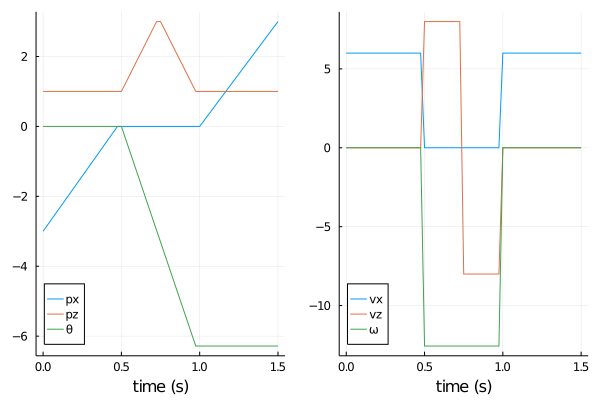

In [15]:
# Plot the reference trajectory
Xref = flip_reference()
p = plot(layout=(1,2))
prob.times
plot!(p[1], prob.times, Xref, inds=1:3, xlabel="time (s)", labels = ["px" "pz" "θ"], legend=:bottomleft)
plot!(p[2], prob.times, Xref, inds=4:6, xlabel="time (s)", labels = ["vx" "vz" "ω"], legend=:bottomleft)

Generate a new time-varying objective that tracks the reference trajectory. Check out the types in `quadratic_cost.jl` for some convenient constructors.

In [21]:
# TASK: design the time-varying tracking objective
#       save it as the variable obj_flip::Vector{<:QuadraticCost}
obj_flip = copy(obj)

# SOLUTION
Uref = [uhover for k = 1:T-1]
obj_flip = map(1:T-1) do k
    LQRCost(Q, R, Xref[k], Uref[k])
end
push!(obj_flip, LQRCost(Qf, R, Xref[end]));

## Part (d): Optimize the Flip Trajectory
Using the reference trajectory and the objective you specified in the previous part, construct a new problem and solve it with your iLQR solver. Use a simple hover trajectory as the initial guess.

In [23]:
# TODO: Solve for Xflip, Uflip, the optimized trajectories to flip the quadrotor

Xflip, Uflip, K, P = deepcopy(X0), deepcopy(U0), [zeros(m,n) for k = 1:T], [zeros(n,n) for k = 1:T]

# SOLUTION
prob_flip = Problem(model, obj_flip, tf, x0)

# Initial guess
X0 = [x0 for k = 1:T]
U0 = [uhover for k = 1:T-1]

Xflip, Uflip, K, P = solve_ilqr(prob_flip, X0, U0, verbose=1);

Iter:   1, Cost:  6735.83 →  6477.45 ( 2.58e+02), res:  9.44e+01, β= 1.00e-06, α = 1.000
Iter:   2, Cost:  6477.45 →  5183.67 ( 1.29e+03), res:  1.73e+02, β= 1.00e-06, α = 0.500
Iter:   3, Cost:  5183.67 →  1564.44 ( 3.62e+03), res:  1.95e+02, β= 1.00e-06, α = 1.000
Iter:   4, Cost:  1564.44 →  1012.99 ( 5.51e+02), res:  1.03e+02, β= 1.00e-06, α = 0.250
Iter:   5, Cost:  1012.99 →  620.74 ( 3.92e+02), res:  6.45e+01, β= 1.00e-06, α = 0.500
Iter:   6, Cost:  620.74 →  508.92 ( 1.12e+02), res:  4.42e+01, β= 1.00e-06, α = 1.000
Iter:   7, Cost:  508.92 →  348.80 ( 1.60e+02), res:  5.66e+01, β= 1.00e-06, α = 0.500
Iter:   8, Cost:  348.80 →  264.36 ( 8.44e+01), res:  2.90e+01, β= 1.00e-06, α = 0.500
Iter:   9, Cost:  264.36 →  202.96 ( 6.14e+01), res:  2.46e+01, β= 1.00e-06, α = 0.500
Iter:  10, Cost:  202.96 →  163.75 ( 3.92e+01), res:  2.54e+01, β= 1.00e-06, α = 0.500
Iter:  11, Cost:  163.75 →  140.92 ( 2.28e+01), res:  2.07e+01, β= 1.00e-06, α = 1.000
Iter:  12, Cost:  140.92 →  130.53

In [18]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))))), Set(Any[WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8700))

In [24]:
visualize!(vis, model, tf, Xflip)

## Part (e): Compare to TVLQR
iLQR generates a local linear feedback controller. As we saw in class, the backwardpass in iLQR is basically TVLQR with some extra terms. However, as our trajectory converges to a stationary point, these extra linear terms should go to zero. When iLQR exits, theses local feedback gains should closely match the result out of TVLQR. Using your code from the previous homework, generate a TVLQR solution for the optimized flip trajectory, using the same cost matrices used in your iLQR solver. They should match to reasonable numerical precision.

In [25]:
# TODO: Generate Klqr, Plqr, the feedback and cost-to-go matrices from TVLQR
#       to track the optimized flip trajectory

# SOLUTION:
function tvlqr(A,B,Q,R,Qf)
    # Extract some variables
    T = length(A)+1
    n,m = size(B[1])
    P = [zeros(n,n) for k = 1:T]
    K = [zeros(m,n) for k = 1:T-1]
    
    P[end] .= Qf
    for k = reverse(1:T-1) 
        K[k] .= (R + B[k]'P[k+1]*B[k])\(B[k]'P[k+1]*A[k])
        P[k] .= Q + A[k]'P[k+1]*A[k] - A[k]'P[k+1]*B[k]*K[k]
    end
    
    return K,P
end

A = [zeros(n,n) for k = 1:T-1]
B = [zeros(n,m) for k = 1:T-1]
∇f = RobotDynamics.DynamicsJacobian(model)
for k = 1:T-1
    discrete_jacobian!(RK4, ∇f, model, Xflip[k], Uflip[k], prob.times[k], dt)
    A[k] .= ∇f.A
    B[k] .= ∇f.B
end

Klqr,Plqr = tvlqr(A,B,Q,R,Qf);

In [26]:
@test maximum(norm.(K - Klqr,Inf)) < 1e-3
@test maximum(norm.(P - Plqr,Inf)) < 1e-3

Test Passed

## Part (f): Closed-Loop Tracking
Now that we've seen that the controller generated by iLQR is nearly identical to the TVLQR solution with the same cost matrices, let's use the iLQR gains to track our trajectory, and see how robust it is to wind gusts.

In [29]:
# TODO: Generate two controllers to use in the simulations below:
#       1. LQR controller: Should use the time-varying gains from your iLQR solver
#       2. Open loop: Should use the control trajectory from your iLQR. No feedback.
#       Both controllers should be types that implement the `get_control(ctrl, x, t)` method
#       TIP: Feel free to use structs from HW2

"""
    LQRController

A TVLQR controller that tracks the trajectory specified by `Xref` and `Uref`
using the linear feedback gains `K`.
"""
struct LQRController
    # TODO: add the fields you need
    # SOLUTION
    K::Vector{Matrix{Float64}}
    Xref::Vector{Vector{Float64}}
    Uref::Vector{Vector{Float64}}
    times::Vector{Float64}
end

function get_control(ctrl::LQRController, x, t)
    # TODO: implement the controller
    u = zeros(2)
    # SOLUTION
    k = get_k(ctrl, t)
    K = ctrl.K[k]
    u = ctrl.Uref[k] - K*(x - ctrl.Xref[k])
    return u
end

"""
    OpenLoopController

A controller that just applies an open-loop control policy of sending a 
set trajectory of control values.
"""
struct OpenLoopController
    # TODO: add the fields you need
    # SOLUTION
    Xref::Vector{Vector{Float64}}
    Uref::Vector{Vector{Float64}}
    times::Vector{Float64}
end

function get_control(ctrl::OpenLoopController, x, t)
    # TODO: implement the controller
    u = zeros(2)
    # SOLUTION
    k = get_k(ctrl, t)
    u = ctrl.Uref[k]
    return u
end

# SOLUTION
get_k(controller, t) = searchsortedlast(controller.times, t)

# TODO: Generate controllers
# lqr = LQRController()
# openloop = OpenLoopController()

# SOLUTION
lqr = LQRController(K, Xflip, Uflip, prob.times);
openloop = OpenLoopController(Xflip, Uflip, prob.times);
# END SOLUTION

@test get_control(lqr, Xflip[1], 0.0) - Uflip[1] ≈ zeros(2)

Test Passed

In [30]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))))), Set(Any[WebSocket(server, CONNECTED), WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8700))

In [31]:
# Simulate with LQR
Xlqr, Ulqr, tlqr = simulate(prob.model, Xflip[1], lqr)
visualize!(vis, model, tlqr[end], Xlqr)

Controller ran at 1152.5647286019935 Hz


In [32]:
# Simulate with open-loop controls
Xopen, Uopen, topen = simulate(model, Xflip[1], openloop)
visualize!(vis, model, topen[end], Xopen)

Controller ran at 3297.846522439764 Hz


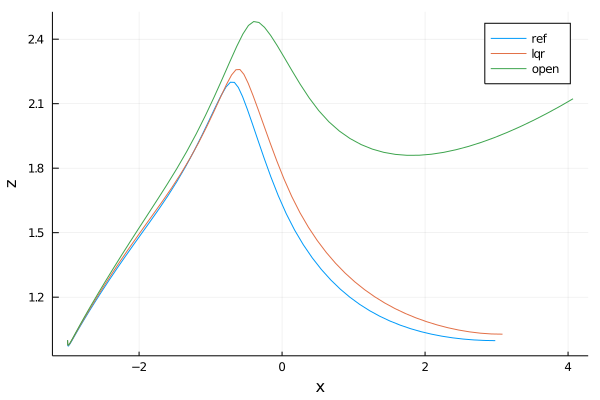

In [33]:
# Plot the trajectories
traj2(Xflip, label="ref")
traj2!(Xlqr, label="lqr")
traj2!(Xopen, label="open", ylabel="z")

## Tests

In [46]:
run_tests();

Total Time: 56.370141999999994 ms
Total Time: 17.677253 ms
Test Summary: | Pass  Total
Q1            |  152    152


## EXTRA CREDIT
If we plot the controls for the flip trajectory (shown below), you'll notice that the controls go negative, which is unrealistic for most quadrotors. Find a way to ensure that the inputs don't go negative while executing the flip trajectory.

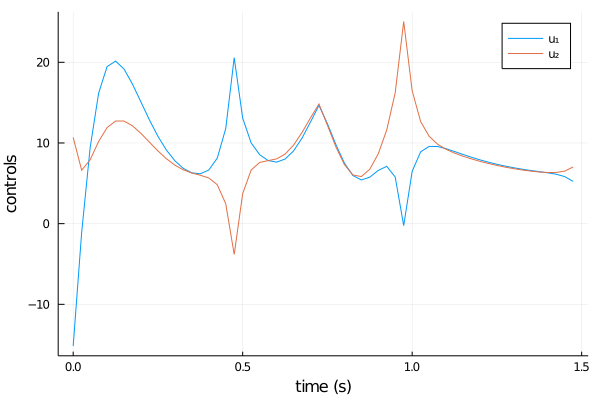

In [34]:
plot(prob.times[1:end-1], Uflip, xlabel="time (s)", ylabel="controls", label=["u₁" "u₂"])